In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

1. Setup and Data Loading
First, let's import all necessary libraries and load our data.

In [22]:
def load_and_prepare_data():
    train_data = pd.read_csv('dataset/network_traffic_training_demo.csv')
    test_data = pd.read_csv('dataset/network_traffic_test_demo.csv')
    
    # Convert timestamp to datetime
    train_data['timestamp'] = pd.to_datetime(train_data['timestamp'])
    test_data['timestamp'] = pd.to_datetime(test_data['timestamp'])

     # Shuffle the datasets
    train_data = train_data.sample(frac=1, random_state=42).reset_index(drop=True)
    test_data = test_data.sample(frac=1, random_state=42).reset_index(drop=True)
    
    return train_data, test_data

In [23]:
train_data, test_data = load_and_prepare_data()

In [24]:
# Display first few rows and basic information
print("Training Data Shape:", train_data.shape)
print("\nFirst few rows of training data:")
display(train_data.head(20))
print("\nData Info:")
display(train_data.info())

Training Data Shape: (10000, 10)

First few rows of training data:


,timestamp,source_ip,dest_ip,protocol,port,bytes,packets,duration,is_attack,pattern_type
0,2025-01-06 08:16:20.487854,192.168.55.224,192.168.38.139,TCP,443,520,3,0.491867,0,normal
1,2025-01-06 12:34:26.375331,192.168.67.94,192.168.80.200,UDP,443,804,7,0.210062,0,normal
2,2025-01-06 06:50:30.159073,192.168.80.184,192.168.8.193,UDP,123,1179,9,0.370990,0,normal
3,2025-01-06 20:27:29.379664,116.20.151.125,192.168.17.56,TCP,80,1431,14,1.601997,0,normal
4,2025-01-06 07:47:19.363695,114.67.130.16,192.168.79.116,TCP,80,1628,12,0.747267,0,normal
5,2025-01-06 06:14:22.494281,19.140.41.244,192.168.244.164,TCP,80,1760,16,0.628329,0,normal
6,2025-01-06 01:36:23.070965,80.166.23.92,192.168.51.36,TCP,443,1670,9,0.595230,0,normal
7,2025-01-06 09:47:45.412550,200.47.113.242,192.168.61.192,TCP,80,876,6,0.287181,0,normal
8,2025-01-06 03:09:36.495969,215.155.252.6,192.168.17.107,TCP,80,1081,6,1.935700,0,normal
9,2025-01-06 21:27:10.059999,218.117.208.192,192.168.218.59,TCP,443,1415,16,0.748444,0,normal



Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   timestamp     10000 non-null  datetime64[ns]
 1   source_ip     10000 non-null  object        
 2   dest_ip       10000 non-null  object        
 3   protocol      10000 non-null  object        
 4   port          10000 non-null  int64         
 5   bytes         10000 non-null  int64         
 6   packets       10000 non-null  int64         
 7   duration      10000 non-null  float64       
 8   is_attack     10000 non-null  int64         
 9   pattern_type  10000 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(4), object(4)
memory usage: 781.4+ KB


None

In [25]:
print(test_data['dest_ip'].dtype)

object


2. Exploratory Data Analysis
Let's analyze our data before preprocessing.

Basic Statistics:


,timestamp,port,bytes,packets,duration,is_attack
count,10000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,2025-01-06 11:46:52.750893056,567.219100,7495.020900,90.894800,0.822817,0.30000
min,2025-01-05 23:47:52.629994,2.000000,40.000000,1.000000,0.001001,0.00000
25%,2025-01-06 05:48:03.305501184,80.000000,651.000000,7.000000,0.206886,0.00000
50%,2025-01-06 11:46:27.247109632,123.000000,1131.000000,11.000000,0.627884,0.00000
75%,2025-01-06 17:43:02.095070208,443.000000,1742.000000,16.000000,1.128788,1.00000
max,2025-01-06 23:47:43.496367,8080.000000,99637.000000,1992.000000,4.991492,1.00000
std,NaN,1587.517504,19214.289043,299.013896,0.835084,0.45828


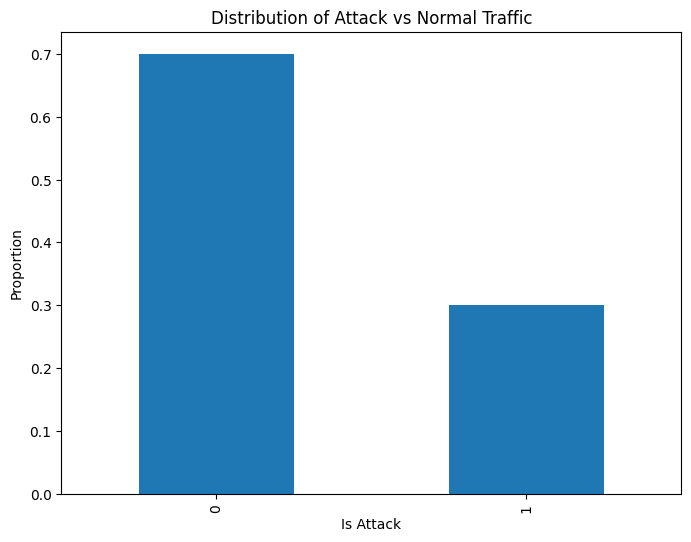

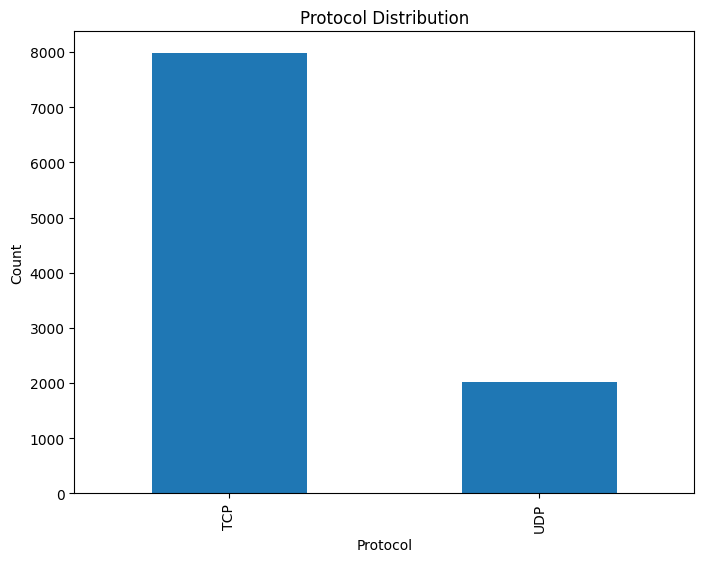

In [26]:
# Basic statistics of numerical columns
print("Basic Statistics:")
display(train_data.describe())

# Distribution of attack vs normal traffic
plt.figure(figsize=(8, 6))
train_data['is_attack'].value_counts(normalize=True).plot(kind='bar')
plt.title('Distribution of Attack vs Normal Traffic')
plt.xlabel('Is Attack')
plt.ylabel('Proportion')
plt.show()

# Protocol distribution
plt.figure(figsize=(8, 6))
train_data['protocol'].value_counts().plot(kind='bar')
plt.title('Protocol Distribution')
plt.xlabel('Protocol')
plt.ylabel('Count')
plt.show()

3. Feature Engineering
Now let's create additional features for our model.

In [27]:
def engineer_features(df):
    # Create a copy to avoid modifying original data
    df = df.copy()
    
    # Create time-based features
    df['hour'] = df['timestamp'].dt.hour
    df['day_of_week'] = df['timestamp'].dt.dayofweek
    
    # Create network-based features
    df['bytes_per_packet'] = df['bytes'] / df['packets']
    df['packet_rate'] = df['packets'] / df['duration']
    
    # Handle infinite values
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.fillna(0)
    
    # Encode categorical variables
    le = LabelEncoder()
    df['protocol_encoded'] = le.fit_transform(df['protocol'])
    
    # Extract IP features
    df['source_ip_first_octet'] = df['source_ip'].apply(lambda x: int(x.split('.')[0]))
    df['dest_ip_first_octet'] = df['dest_ip'].apply(lambda x: int(x.split('.')[0]))
    
    return df

# Apply feature engineering
train_data_processed = engineer_features(train_data)
test_data_processed = engineer_features(test_data)

display(train_data_processed.head(10))
# Display new features
print("New features added. Updated columns:")
display(train_data_processed.columns)

,timestamp,source_ip,dest_ip,protocol,port,bytes,packets,duration,is_attack,pattern_type,hour,day_of_week,bytes_per_packet,packet_rate,protocol_encoded,source_ip_first_octet,dest_ip_first_octet
0,2025-01-06 08:16:20.487854,192.168.55.224,192.168.38.139,TCP,443,520,3,0.491867,0,normal,8,0,173.333333,6.099209,0,192,192
1,2025-01-06 12:34:26.375331,192.168.67.94,192.168.80.200,UDP,443,804,7,0.210062,0,normal,12,0,114.857143,33.323423,1,192,192
2,2025-01-06 06:50:30.159073,192.168.80.184,192.168.8.193,UDP,123,1179,9,0.370990,0,normal,6,0,131.000000,24.259403,1,192,192
3,2025-01-06 20:27:29.379664,116.20.151.125,192.168.17.56,TCP,80,1431,14,1.601997,0,normal,20,0,102.214286,8.739090,0,116,192
4,2025-01-06 07:47:19.363695,114.67.130.16,192.168.79.116,TCP,80,1628,12,0.747267,0,normal,7,0,135.666667,16.058508,0,114,192
5,2025-01-06 06:14:22.494281,19.140.41.244,192.168.244.164,TCP,80,1760,16,0.628329,0,normal,6,0,110.000000,25.464354,0,19,192
6,2025-01-06 01:36:23.070965,80.166.23.92,192.168.51.36,TCP,443,1670,9,0.595230,0,normal,1,0,185.555556,15.120210,0,80,192
7,2025-01-06 09:47:45.412550,200.47.113.242,192.168.61.192,TCP,80,876,6,0.287181,0,normal,9,0,146.000000,20.892727,0,200,192
8,2025-01-06 03:09:36.495969,215.155.252.6,192.168.17.107,TCP,80,1081,6,1.935700,0,normal,3,0,180.166667,3.099654,0,215,192
9,2025-01-06 21:27:10.059999,218.117.208.192,192.168.218.59,TCP,443,1415,16,0.748444,0,normal,21,0,88.437500,21.377694,0,218,192


New features added. Updated columns:


Index(['timestamp', 'source_ip', 'dest_ip', 'protocol', 'port', 'bytes',
       'packets', 'duration', 'is_attack', 'pattern_type', 'hour',
       'day_of_week', 'bytes_per_packet', 'packet_rate', 'protocol_encoded',
       'source_ip_first_octet', 'dest_ip_first_octet'],
      dtype='object')

4. Feature Selection and Preparation
Let's prepare our features for modeling.

In [28]:
def prepare_features(df):
    feature_columns = [
        'bytes', 'packets', 'duration', 'bytes_per_packet', 'packet_rate',
        'protocol_encoded', 'port', 'hour', 'day_of_week',
        'source_ip_first_octet', 'dest_ip_first_octet'
    ]
    
    X = df[feature_columns]
    y = df['is_attack']
    
    return X, y

# Prepare features
X_train, y_train = prepare_features(train_data_processed)
X_test, y_test = prepare_features(test_data_processed)

print("Training features shape:", X_train.shape)
print("Testing features shape:", X_test.shape)

Training features shape: (10000, 11)
Testing features shape: (10000, 11)


5. Model Training and Evaluation
Now let's train our model and evaluate its performance.

The StandardScaler transforms the data so that the mean of each feature becomes 0 and the standard deviation becomes 1. 

This is achieved by the formula:
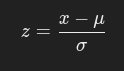

Where:

    x is the original value.
    μ is the mean of the feature.
    σ is the standard deviation of the feature.
    z is the standardized value.
Range of the Transformed Data:

    Mean: The mean of the feature after transformation will be 0.
    Standard deviation: The standard deviation of the feature after transformation will be 1.

In [29]:
def train_and_evaluate_model(X_train, X_test, y_train, y_test):
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train model
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test_scaled)
    y_pred_prob = model.predict_proba(X_test_scaled)
    
    return model, scaler,  y_pred, y_pred_prob, X_train_scaled, X_test_scaled

# Train and evaluate
model, scaler, y_pred, y_pred_prob, X_train_scaled, X_test_scaled = train_and_evaluate_model(
    X_train, X_test, y_train, y_test
)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7000
           1       1.00      1.00      1.00      3000

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



6. Visualization of Results
Let's visualize our model's performance.

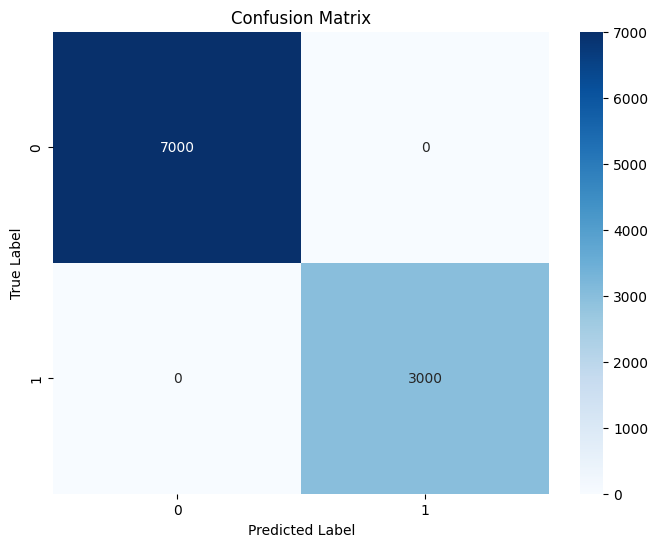

In [30]:
# Confusion Matrix
def plot_confusion_matrix(y_test, y_pred):
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

plot_confusion_matrix(y_test, y_pred)

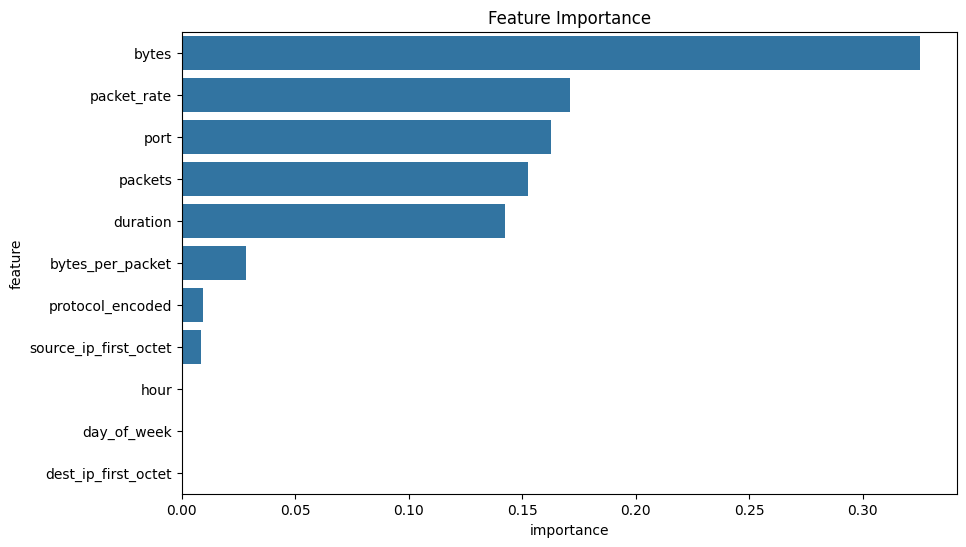

In [31]:
# Feature Importance
def plot_feature_importance(model, feature_columns):
    importances = pd.DataFrame({
        'feature': feature_columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=importances)
    plt.title('Feature Importance')
    plt.show()

plot_feature_importance(model, X_train.columns)

In [32]:
import joblib

# Save the model and scaler
joblib.dump(model, 'threat_detection_model_demo.joblib')
joblib.dump(scaler, 'feature_scaler_demo.joblib')

print("Model and scaler saved successfully!")

Model and scaler saved successfully!


In [33]:
# First, let's create a small sample of new traffic data to test prediction
new_traffic_data = pd.DataFrame({
    'timestamp': [pd.Timestamp.now()],
    'source_ip': ['192.168.1.1'],
    'dest_ip': ['10.0.0.1'],
    'protocol': ['TCP'],
    'port': [80],
    'bytes': [1500],
    'packets': [10],
    'duration': [0.5],
    # Note: we don't need to include 'is_attack' since we're predicting it
})

In [34]:
loaded_model = joblib.load('threat_detection_model_demo.joblib')
loaded_scaler = joblib.load('feature_scaler_demo.joblib')

In [35]:
def predict_with_loaded_model(loaded_model, loaded_scaler, new_data):
    # Preprocess new data
    processed_data = engineer_features(new_data)
    feature_columns = [
        'bytes', 'packets', 'duration', 'bytes_per_packet', 'packet_rate',
        'protocol_encoded', 'port', 'hour', 'day_of_week',
        'source_ip_first_octet', 'dest_ip_first_octet'
    ]
    X_new = processed_data[feature_columns]
    
    # Scale features using loaded scaler
    X_new_scaled = loaded_scaler.transform(X_new)
    
    # Make predictions
    predictions = loaded_model.predict(X_new_scaled)
    probabilities = loaded_model.predict_proba(X_new_scaled)[:, 1]
    
    # Create results DataFrame
    results = pd.DataFrame({
        'Prediction': ['Attack' if p == 1 else 'Normal' for p in predictions],
        'Confidence': probabilities,
        'Original_Source_IP': new_data['source_ip'],
        'Original_Dest_IP': new_data['dest_ip'],
        'Original_Protocol': new_data['protocol']
    })
    
    return results

In [36]:
new_traffic = pd.DataFrame({
    'timestamp': [pd.Timestamp.now(), pd.Timestamp.now()],
    'source_ip': ['192.168.1.1', '45.123.45.67'],
    'dest_ip': ['10.0.0.1', '192.168.1.100'],
    'protocol': ['TCP', 'UDP'],
    'port': [80, 443],
    'bytes': [1500, 15000],
    'packets': [10, 500],
    'duration': [0.5, 0.1]
})

In [37]:
# Make predictions using loaded model and scaler
results = predict_with_loaded_model(loaded_model, loaded_scaler, new_traffic)
print("Prediction Results:")
display(results)

Prediction Results:


,Prediction,Confidence,Original_Source_IP,Original_Dest_IP,Original_Protocol
0,Normal,0.0,192.168.1.1,10.0.0.1,TCP
1,Attack,1.0,45.123.45.67,192.168.1.100,UDP


In [38]:
# Test with more distinct patterns
test_traffic = pd.DataFrame({
    # Normal traffic
    'timestamp': [pd.Timestamp.now(), 
                 pd.Timestamp.now(), 
                 pd.Timestamp.now()],
    'source_ip': ['192.168.1.1',                    # Internal IP (normal)
                 '45.123.45.67',                    # External IP (suspicious)
                 '98.76.54.32'],                    # External IP (suspicious)
    'dest_ip': ['10.0.0.1', 
                '192.168.1.100', 
                '192.168.1.1'],
    'protocol': ['TCP', 'UDP', 'TCP'],
    'port': [80,                                    # Normal web port
             443,                                   # Normal HTTPS port
             22],                                   # SSH port (could be suspicious)
    'bytes': [1500,                                # Normal size
              15000,                               # Very high (suspicious)
              500],                                # Small (potential probe)
    'packets': [10,                                # Normal count
                500,                               # Very high (suspicious)
                2],                                # Very low (potential scan)
    'duration': [0.5,                              # Normal duration
                 0.1,                              # Too quick for high volume (suspicious)
                 0.01]                             # Very quick (suspicious)
})

# Make predictions
results = predict_with_loaded_model(loaded_model, loaded_scaler, test_traffic)
print("Prediction Results:")
display(results)

Prediction Results:


,Prediction,Confidence,Original_Source_IP,Original_Dest_IP,Original_Protocol
0,Normal,0.00,192.168.1.1,10.0.0.1,TCP
1,Attack,1.00,45.123.45.67,192.168.1.100,UDP
2,Attack,0.85,98.76.54.32,192.168.1.1,TCP
